# Setup

In [48]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [49]:
columns_basic = [
    'timedelta', 'user_id', 'is_speaking'
]

columns_head = [
    'gaze_on', 'nod_no', 'nod_yes', 'smile'
]


In [50]:
os.listdir('./videos')

['1a19835c-4dd1-4d29-b945-e0b25285a26a',
 '542a6af4-84f3-4681-80ce-fce29162efc1',
 '01a4c01c-cf0e-4f37-ab2b-641bb604af30',
 '9f3ab90a-2c3c-4774-a703-f6188d446397',
 '41126a20-ce2c-4eab-90af-9455356e03bb',
 'fe4a5de5-3b9c-4b6f-8e70-403db8a1caec',
 'b9cb85c5-1a07-4907-b6c7-0147ad88ab13',
 '81f75ece-fc36-405f-a281-a28213a8707d',
 '53bcbe13-1160-4bd3-9eda-ea946079142d',
 '7f32f80f-9412-43c2-87c1-df810a781a94',
 '8f6efa76-f5ce-4d71-9dbf-c1b8670cca44',
 '9f6aae7d-7d98-45c1-b2aa-b9ea12b6b114',
 'a30fcd70-b96b-444a-baa1-2a340bb74cb0',
 '57508710-6147-4bae-b578-03ad505df3df',
 'c23b499d-8fde-417a-95fb-958413323675',
 '32adb5d5-910d-4547-972a-f5d0b795c689',
 'bc7e2c9b-4435-412b-a9e8-78fe86437610',
 '243349a8-ddca-43f5-bfa7-3ece849fc8e5',
 'a63a1c8c-6511-4817-8217-449bdbbbd0ca',
 '4652239e-2e52-4454-bc57-ac93467deae6',
 'd777011c-80d2-4345-8977-e472d8ef479a',
 '8bc5f32a-afbc-40d0-9037-9baef0e7182c',
 '1f8de023-817f-4a7b-aefd-bcb1184a1d9a',
 '3b0194a8-6776-4c86-9696-19b9268d548a',
 '4be7675a-c2e4-

In [51]:
# data opening
videos = os.listdir('./videos/')

# surveys = []
features = []
full_dfs = []
audio_dfs = []
emotion_dfs = []
head_dfs = []
transcript_dfs = []

for video in videos:
    # f_survey = open(f'{video}/survey.csv', 'r')
    # surveys.append(pd.read_csv(f_survey))
    if video == '.DS_Store':
        continue

    f_features = open(f'./videos/{video}/audio_video_features.csv', 'r')
    df = pd.read_csv(f_features)

    t_features = open(f'./videos/{video}/transcription/transcript_audiophile.csv', 'r')
    t_df = pd.read_csv(t_features)

    # make it more readable
    username1 = df['user_id'].unique()[0]
    username2 = df['user_id'].unique()[1]

    df['user_id'] = df['user_id'].replace(username1, "Bob")
    df['user_id'] = df['user_id'].replace(username2, "Joe")

    t_df['speaker'] = t_df['speaker'].replace(username1, "Bob")
    t_df['speaker'] = t_df['speaker'].replace(username2, "Joe")

    # append the datasets    
    full_dfs.append(df)
    head_dfs.append(df[columns_basic + columns_head])


In [52]:
import json
from datetime import timedelta
import math

# extract N time windows from the video
def trim(video, _df):
    """
        Masks the dataframe by the time both the speakers arrive
    """
    try:
        transcript = pd.read_csv(f'videos/{video}/transcription/transcript_cliffhanger.csv')
    except FileNotFoundError:
        raise FileNotFoundError(f"Transcript file for {video} not found.")
    
    i = 0
    start = 0

    # sometimes the first person to arrive speaks but there is nobody
    while i + 1 < len(transcript):
        start1 = math.floor(transcript['start'].values[i])
        start2 = math.floor(transcript['start'].values[i+1])
        
        # check if there is a response to the first utterance in less than 5s
        if start2-start1 < 5:
            start = start1
            break
        else:
            i+=1
    stop = math.ceil(transcript['stop'].values[-1])

    # mask the rows
    df = _df.copy()
    df['seconds'] = df['timedelta'].apply(lambda x: pd.Timedelta(x).seconds)
    mask = (df['seconds'] >= start) & (df['seconds'] <= stop)
    selected_rows = df[mask]

    return selected_rows, start, stop

In [53]:
OFFSET_SIZE = 3 * 60 # 3min in seconds

def slice_video(_df, start, stop):
    df = _df.copy()
    offset_mask = (df['seconds'] >= start + OFFSET_SIZE) & (df['seconds'] <= stop - OFFSET_SIZE)
    df = df[offset_mask]

    return df

In [54]:
trimmed_head = []

for i in range(len(head_dfs)):
    if videos[i] == '.DS_Store':
        continue

    trimmed, start, stop = trim(videos[i], head_dfs[i])
    window = slice_video(trimmed, start, stop)
    metrics = ['nod_yes', 'nod_no', 'gaze_on', 'smile']
    window[metrics] = window[metrics].fillna(0)
    
    trimmed_head.append(window)

In [55]:
print(len(trimmed_head))
print(trimmed_head[0])

55
     timedelta user_id  is_speaking  gaze_on  nod_no  nod_yes  smile  seconds
512   00:04:16     Bob        False      1.0     0.0      0.0    0.0      256
513   00:04:16     Joe         True      0.0     0.0      0.0    0.0      256
514   00:04:17     Bob        False      1.0     0.0      0.0    0.0      257
515   00:04:17     Joe         True      0.0     0.0      0.0    0.0      257
516   00:04:18     Bob        False      1.0     0.0      0.0    0.0      258
...        ...     ...          ...      ...     ...      ...    ...      ...
2937  00:24:28     Joe         True      0.0     0.0      0.0    0.0     1468
2938  00:24:29     Bob        False      0.0     0.0      0.0    0.0     1469
2939  00:24:29     Joe         True      1.0     0.0      0.0    1.0     1469
2940  00:24:30     Bob        False      1.0     0.0      0.0    0.0     1470
2941  00:24:30     Joe         True      0.0     0.0      0.0    0.0     1470

[2430 rows x 8 columns]


# Preprocessing

In [9]:
# import matplotlib.cm as cm
# from scipy.interpolate import interp1d
# import matplotlib.pyplot as plt
# import math

# fig, axes = plt.subplots(11, 5, figsize=(20, 30))
# video_index = 0
# colors = cm.get_cmap('tab10', 10)  # Get a colormap with 10 distinct colors
# for video_data in windows:
#     users = video_data['user_id']
#     user_ids = np.unique(users)
    
#     if len(user_ids) < 2:
#         continue  # Skip this video if there are less than 2 users
    
#     row = video_index // 5
#     col = video_index % 5
    
#     for i, user_id_1 in enumerate(user_ids):
#         for j, user_id_2 in enumerate(user_ids):
#             if i >= j:
#                 continue  # Avoid duplicate plots and self-comparison
            
#             user_data_1 = video_data[video_data['user_id'] == user_id_1]
#             user_data_2 = video_data[video_data['user_id'] == user_id_2]
            
#             cum_nod_yes_1 = user_data_1['cum_nod_yes']
#             cum_nod_yes_2 = user_data_2['cum_nod_yes']
            
#             # Ensure both users have the same number of data points
#             min_len = min(len(cum_nod_yes_1), len(cum_nod_yes_2))
#             cum_nod_yes_1 = cum_nod_yes_1[:min_len]
#             cum_nod_yes_2 = cum_nod_yes_2[:min_len]
            
#             color_1 = colors(i % 10)
#             color_2 = colors(j % 10)
            
#             axes[row, col].scatter(cum_nod_yes_1, cum_nod_yes_2, label=f'User {user_id_1} vs User {user_id_2}', color=color_1)
#             axes[row, col].scatter(cum_nod_yes_2, cum_nod_yes_1, label=f'User {user_id_2} vs User {user_id_1}', color=color_2)
    
#     axes[row, col].set_title(f'Video {video_index+1}')  # Title each subplot with video number
#     axes[row, col].set_xlabel('Cumulative Nods of User 1')
#     axes[row, col].set_ylabel('Cumulative Nods of User 2')
#     axes[row, col].legend()

#     video_index += 1
# plt.tight_layout()

# Similarity Measures

In [56]:
from scipy.spatial import distance
from sklearn.metrics.cluster import rand_score

def normalize(data):
  return (data - np.min(data)) / (np.max(data) - np.min(data))

def cosine_similarity(x, y):
  return np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))

def jaccard(x, y):
  return distance.jaccard(x, y)

def euclidean_distance(x, y):
  return np.sqrt(np.sum(np.square(x - y)))

def jaccard_similarity(x, y):
  intersection = sum(x & y for x, y in zip(x, y))
  union = sum(x | y for x, y in zip(x, y))
  return intersection / union if union != 0 else 0

def hamming_distance(x, y):
  return sum(x != y for x, y in zip(x, y))

def pearson_correlation(x, y):
  return np.corrcoef(x, y)[0, 1]

import pandas as pd

def smc(x, y):
    m1 = [l for l in x]
    m2 = [l for l in y]

    cross = pd.crosstab(m1, m2)
    smc = 0.0  # Initialize smc with a default value
    if cross.shape == (2, 2):
        a = cross.iloc[0,0]
        b = cross.iloc[0,1]
        c = cross.iloc[1,0]
        d = cross.iloc[1,1]
        smc = (a + d) / (a + b + c + d)

    return smc

def rand(vector1, vector2):
    rand = rand_score(vector1, vector2)
    return rand

# Analysis 2

In [57]:
# Create user frame
data = []
for video in videos:
    data_ = []
    with open(f'./videos/{video}/audio_video_features.csv', 'r') as f_features:
        feature_df = pd.read_csv(f_features)
    u1 = feature_df['user_id'].unique()[0] # Bob
    u2 = feature_df['user_id'].unique()[1] # Joe
    idx = videos.index(video)

    data_.append(idx)
    data_.append(video)
    data_.append(u1)
    data_.append(u2)
    data.append(data_)

users_df = pd.DataFrame(data, columns=['video_idx', 'video', 'un_bob', 'un_joe'])
users_df.head()

,video_idx,video,un_bob,un_joe
0,0,1a19835c-4dd1-4d29-b945-e0b25285a26a,5ed1e0f7ba6548028fc64722,5f641cfa0c8b8b19b424aa4d
1,1,542a6af4-84f3-4681-80ce-fce29162efc1,5e3309ad239ceb2d47d47c4a,5effc7a64495250cbb0d8de8
2,2,01a4c01c-cf0e-4f37-ab2b-641bb604af30,5e6cade3d92ffb26677dbd84,5f1b2282a3103e2caff2fd7b
3,3,9f3ab90a-2c3c-4774-a703-f6188d446397,5d37c1724803980016b2207e,5eb0c3f05aeb111911ad74de
4,4,41126a20-ce2c-4eab-90af-9455356e03bb,5e7072e5fb136c63e94f3fa4,5f375d51fae4971ed086f809


In [58]:
from scipy.stats import chi2_contingency
import numpy as np

data = []
RANDOM_PEOPLE_NUM = 1
metrics = ['nod_yes', 'nod_no', 'gaze_on', 'smile']

for video in videos:
    for metric in metrics:
        video_index = videos.index(video)
        current_video = trimmed_head[video_index]
        bob = current_video[current_video['user_id'] == 'Bob'][metric]
        joe = current_video[current_video['user_id'] == 'Joe'][metric]

        min_l = min(len(bob), len(joe))
        bob = bob[:min_l]
        joe = joe[:min_l]
        # within_similarity = smc(bob, joe)
        within_similarity = distance.jaccard(bob, joe)

        bob_userid = users_df.iloc[video_index]['un_bob']
        joe_userid = users_df.iloc[video_index]['un_joe']

        npv = users_df[(users_df['un_bob'] != bob_userid) &
                       (users_df['un_joe'] != bob_userid) &
                       (users_df['un_bob'] != joe_userid) &
                       (users_df['un_joe'] != joe_userid)]['video_idx'].values
        
        non_partners = []
        for _video in npv:
            comp_video = trimmed_head[_video]
            person = comp_video[comp_video['user_id']=='Bob'][metric]
            non_partners.append(person)
        
        bob_similarities = []
        joe_similarities = []
        for np in non_partners:
            np = np.values

            min_l_b = min(len(bob), len(np))
            bob_copy = bob[:min_l_b]
            np_bob = np[:min_l_b]
            bob_sim = distance.jaccard(bob_copy, np_bob)
            # bob_sim = smc(bob_copy, np_bob)
            bob_similarities.append(bob_sim)

            min_l_j = min(len(joe), len(np))
            joe_copy = joe[:min_l_j]
            np_joe = np[:min_l_j]
            joe_sim = distance.jaccard(joe_copy, np_bob)
            # joe_sim = smc(joe_copy, np_bob)
            joe_similarities.append(joe_sim)

        bob_sim_mean = sum(bob_similarities) / len(bob_similarities)
        joe_sim_mean = sum(joe_similarities) / len(joe_similarities)

        data.append([video_index, metric, within_similarity, bob_sim_mean, joe_sim_mean])
df = pd.DataFrame(data, columns=['vid_idx', 'metric', 'bob and joe', 'bob et al', 'joe et al'])
df.head(50)


,vid_idx,metric,bob and joe,bob et al,joe et al
0,0,nod_yes,0.974790,0.977517,0.976346
1,0,nod_no,1.000000,0.982628,0.991752
2,0,gaze_on,0.984000,0.714169,0.986501
3,0,smile,0.925743,0.855494,0.940976
4,1,nod_yes,0.989011,0.966794,0.995396
5,1,nod_no,1.000000,0.975369,0.988703
6,1,gaze_on,0.775432,0.693989,0.867518
7,1,smile,0.712357,0.829940,0.732126
8,2,nod_yes,0.992188,0.978709,0.978755
9,2,nod_no,0.963303,0.983013,0.977945


In [59]:
from scipy import stats

global_entrainment = {}

for metric in metrics:
    global_entrainment[metric] = {} 
    metric_start = df[df['metric']==metric]['bob and joe']
    metric_end1 =  df[df['metric']==metric]['bob et al']
    metric_end2 =  df[df['metric']==metric]['joe et al']
    metric_start_mean = metric_start.mean()
    metric_end1_mean = metric_end1.mean()
    metric_end2_mean = metric_end2.mean()

    _, p1 = stats.ttest_rel(metric_start.values, metric_end1.values)
    _, p2 = stats.ttest_rel(metric_start.values, metric_end2.values)
    
    global_entrainment[metric]['p_bob_vs_random'] = str(p1)
    global_entrainment[metric]['p_joe_vs_random'] = str(p2)
    global_entrainment[metric]['mean_start'] = metric_start_mean
    global_entrainment[metric]['mean_end_1'] = metric_end1_mean
    global_entrainment[metric]['mean_end_2'] = metric_end2_mean
    global_entrainment[metric]['diff1'] = metric_end1_mean-metric_start_mean
    global_entrainment[metric]['diff2'] = metric_end2_mean-metric_start_mean

In [60]:
for k in global_entrainment.keys():
    print(f"{k} p_bob_vs_random {global_entrainment[k]['p_bob_vs_random']}")
    print(f"{k} p_joe_vs_random {global_entrainment[k]['p_joe_vs_random']}")
    print(f"{k} mean_start {global_entrainment[k]['mean_start']}")
    print(f"{k} mean_end_1 {global_entrainment[k]['mean_end_1']}")
    print(f"{k} mean_end_2 {global_entrainment[k]['mean_end_2']}")
    print(f"{k} diff1 {global_entrainment[k]['diff1']}")
    print(f"{k} diff2 {global_entrainment[k]['diff2']}")

    print()

nod_yes p_bob_vs_random 0.00439525100000446
nod_yes p_joe_vs_random 0.08278118045948475
nod_yes mean_start 0.9799077515856941
nod_yes mean_end_1 0.9730797120524284
nod_yes mean_end_2 0.9753250389513584
nod_yes diff1 -0.006828039533265717
nod_yes diff2 -0.004582712634335739

nod_no p_bob_vs_random 0.1164151570741723
nod_no p_joe_vs_random 0.33607394211437946
nod_no mean_start 0.9811824752347581
nod_no mean_end_1 0.9771944685121937
nod_no mean_end_2 0.9786520190260656
nod_no diff1 -0.003988006722564386
nod_no diff2 -0.002530456208692522

gaze_on p_bob_vs_random 0.517023165023136
gaze_on p_joe_vs_random 0.26243860445943606
gaze_on mean_start 0.8038605725411139
gaze_on mean_end_1 0.8285083759588524
gaze_on mean_end_2 0.8450647733504693
gaze_on diff1 0.024647803417738534
gaze_on diff2 0.041204200809355385

smile p_bob_vs_random 0.3275341992471027
smile p_joe_vs_random 0.6804654211659649
smile mean_start 0.8174495830236025
smile mean_end_1 0.8440691086940142
smile mean_end_2 0.82873385196677

# ANALYSIS 2 done

In [15]:
# from scipy.stats import chi2_contingency
# data = []
# RANDOM_PEOPLE_NUM = 1
# metrics = ['nod_yes', 'nod_no', 'gaze_on', 'smile']
# within_similarities = []
# between_similarities = []


# for video in videos:
#     for metric in metrics:
#         vid_idx = videos.index(video)
#         current_video = trimmed_head[vid_idx]
#         bob = current_video[current_video['user_id']=='Bob'][metric]
#         # bobs = [l for l in bob]
#         # print(bobs)
#         joe = current_video[current_video['user_id']=='Joe'][metric]
#         # joes = [l for l in joe]
#         # print(joes)

#         min_length = min(len(bob), len(joe))
#         bob = bob[:min_length]
#         joe = joe[:min_length]
#         within_similarity = smc(bob, joe)
#         # print(bob)
#         # print(joe)

#         bob_userid = users_df.iloc[vid_idx]['un_bob']
#         joe_userid = users_df.iloc[vid_idx]['un_joe']
#         # print(bob_userid)
#         # print(joe_userid)

#         non_partners_videos = users_df[(users_df['un_bob'] != bob_userid) & (users_df['un_joe'] != bob_userid) \
#                                        & (users_df['un_bob'] != joe_userid) & (users_df['un_joe'] != joe_userid)]['video_idx'].values# [:RANDOM_PEOPLE_NUM]
        
#         non_partner_vid_idx = non_partners_videos[0]
#         non_partner_video = trimmed_head[non_partner_vid_idx]
#         non_partner = non_partner_video[non_partner_video['user_id'] == 'Bob'][metric]

#         b_min_length = min(len(bob), len(non_partner))
#         bob = bob[:b_min_length]
#         non_partner = non_partner[:b_min_length]

#         bob_between_similarity = smc(bob, non_partner)

#         min_length = min(len(joe), len(non_partner))
#         joe = joe[:min_length]
#         non_partner =  non_partner[:min_length]

#         joe_between_similarity = smc(joe, non_partner)

#         bob_others_df = pd.DataFrame({'m1': bob, 'm2': non_partner})
#         joe_others_df = pd.DataFrame({'m1': joe, 'm2': non_partner})

#         bob_others_contingency = pd.crosstab(bob_others_df['m1'], bob_others_df['m2'], dropna=False)
#         chi2_end, bob_others_pvalue, _, _ = chi2_contingency(bob_others_contingency, correction=True)

#         joe_others_contingency = pd.crosstab(joe_others_df['m1'], joe_others_df['m2'], dropna=False)
#         chi2_end, joe_others_pvalue, _, _ = chi2_contingency(joe_others_contingency, correction=True)

#         data.append([vid_idx, metric, within_similarity, bob_between_similarity, joe_between_similarity, bob_others_pvalue, joe_others_pvalue])
# df = pd.DataFrame(data, columns=['vid_idx', 'metric', 'bob and joe', 'bob et al', 'joe et al', 'bob others pvalue', 'joe others pvalue'])
# df.head(50)
        

,vid_idx,metric,bob and joe,bob et al,joe et al,bob others pvalue,joe others pvalue
0,0,nod_yes,0.904527,0.888066,0.879835,9.196279e-08,0.0
1,0,nod_no,0.957202,0.914403,0.939095,1.673461e-06,0.0
2,0,gaze_on,0.291358,0.597531,0.239506,8.743083e-11,0.0
3,0,smile,0.692181,0.606584,0.623045,1.926188e-14,0.0
4,1,nod_yes,0.927885,0.888066,0.948148,9.196279e-08,0.0
5,1,nod_no,0.933494,0.914403,0.958025,1.673461e-06,0.0
6,1,gaze_on,0.352564,0.597531,0.417284,8.743083e-11,0.0
7,1,smile,0.450321,0.606584,0.409053,1.926188e-14,0.0
8,2,nod_yes,0.924718,0.920988,0.916049,6.096813e-17,0.0
9,2,nod_no,0.937759,0.946502,0.921811,1.939066e-06,0.0


### Nod yes plots

NameError: name 'windows_head' is not defined

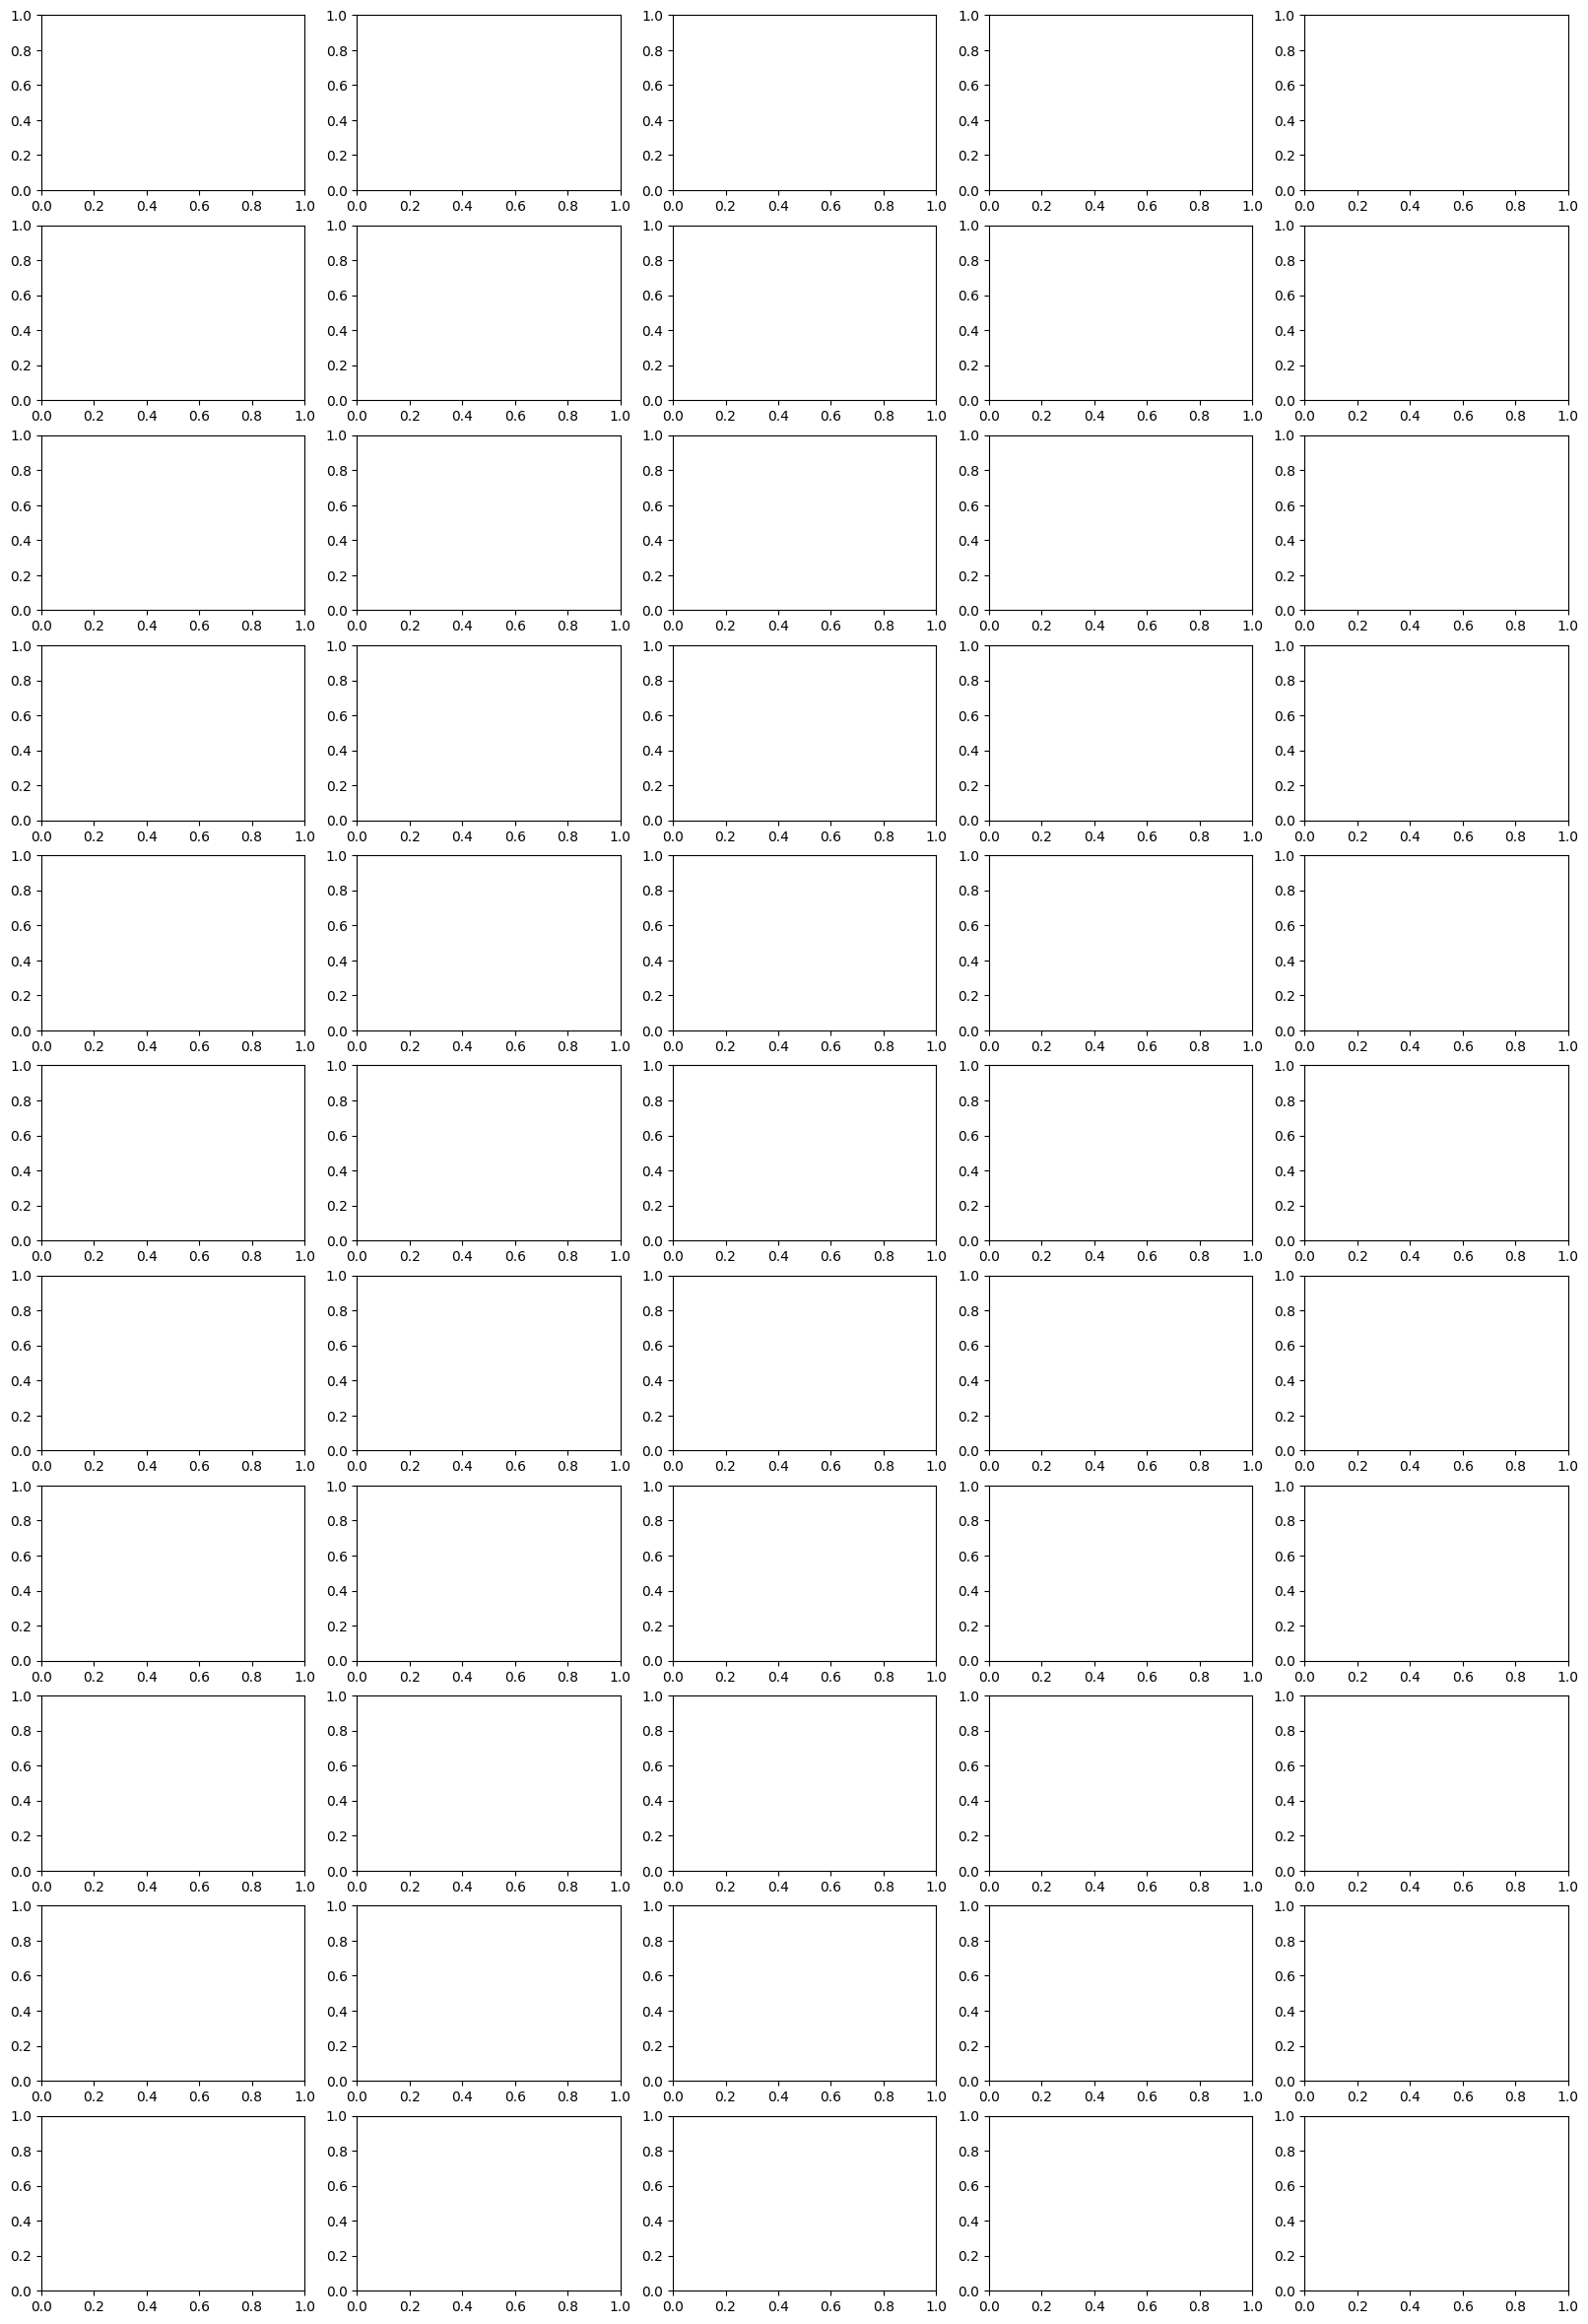

In [16]:
import matplotlib.cm as cm
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import math

fig, axes = plt.subplots(11, 5, figsize=(20, 30))
video_index = 0
for video_data in windows_head:
   users = video_data['user_id'].unique()
   color = ['blue', 'orange']
   color_index = 0
   for u in users:
    nod_yes_cumsum = np.cumsum(video_data[video_data['user_id'] == u]['nod_yes'].fillna(0))
    seconds = [s for s in range(len(video_data[video_data['user_id'] == u]['seconds']))]
    smooth_seconds = np.linspace(min(seconds), max(seconds), 100)
    f = interp1d(seconds, nod_yes_cumsum, kind='linear')
    smooth_nod_yes_cumsum = f(smooth_seconds)
    
    row = video_index // 5
    col = video_index % 5
    color_index = (color_index + 1) % len(color)
    
    # Plot on the corresponding subplot
    axes[row, col].plot(smooth_seconds, smooth_nod_yes_cumsum, label=users, color=color[color_index])
    axes[row, col].set_title(f'Video {video_index+1}')  # Title each subplot with video number
    axes[row, col].set_xlabel('Seconds')
    axes[row, col].set_ylabel('# Nods')
   axes[row, col].legend(users)
   video_index += 1
plt.tight_layout()

### Nod no plots

In [ ]:
import matplotlib.cm as cm
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import math

fig, axes = plt.subplots(11, 5, figsize=(20, 30))
video_index = 0
for video_data in windows_head:
   users = video_data['user_id'].unique()
   color = ['blue', 'orange']
   color_index = 0
   for u in users:
    nod_yes_cumsum = np.cumsum(video_data[video_data['user_id'] == u]['nod_no'].fillna(0))
    seconds = [s for s in range(len(video_data[video_data['user_id'] == u]['seconds']))]
    smooth_seconds = np.linspace(min(seconds), max(seconds), 100)
    f = interp1d(seconds, nod_yes_cumsum, kind='linear')
    smooth_nod_yes_cumsum = f(smooth_seconds)
    
    row = video_index // 5
    col = video_index % 5
    color_index = (color_index + 1) % len(color)
    
    # Plot on the corresponding subplot
    axes[row, col].plot(smooth_seconds, smooth_nod_yes_cumsum, label=users, color=color[color_index])
    axes[row, col].set_title(f'Video {video_index+1}')  # Title each subplot with video number
    axes[row, col].set_xlabel('Seconds')
    axes[row, col].set_ylabel('# Nods')
   axes[row, col].legend(users)
   video_index += 1
plt.tight_layout()

### Gaze on plots

In [ ]:
import matplotlib.cm as cm
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import math

fig, axes = plt.subplots(11, 5, figsize=(20, 30))
video_index = 0
for video_data in windows_head:
   users = video_data['user_id'].unique()
   color = ['blue', 'orange']
   color_index = 0
   for u in users:
    nod_yes_cumsum = np.cumsum(video_data[video_data['user_id'] == u]['gaze_on'].fillna(0))
    seconds = [s for s in range(len(video_data[video_data['user_id'] == u]['seconds']))]
    smooth_seconds = np.linspace(min(seconds), max(seconds), 100)
    f = interp1d(seconds, nod_yes_cumsum, kind='linear')
    smooth_nod_yes_cumsum = f(smooth_seconds)
    
    row = video_index // 5
    col = video_index % 5
    color_index = (color_index + 1) % len(color)
    
    # Plot on the corresponding subplot
    axes[row, col].plot(smooth_seconds, smooth_nod_yes_cumsum, label=users, color=color[color_index])
    axes[row, col].set_title(f'Video {video_index+1}')  # Title each subplot with video number
    axes[row, col].set_xlabel('Seconds')
    axes[row, col].set_ylabel('# Nods')
   axes[row, col].legend(users)
   video_index += 1
plt.tight_layout()

### Smiling plots

In [ ]:
import matplotlib.cm as cm
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import math

fig, axes = plt.subplots(11, 5, figsize=(20, 30))
video_index = 0
for video_data in windows_head:
   users = video_data['user_id'].unique()
   color = ['blue', 'orange']
   color_index = 0
   for u in users:
    nod_yes_cumsum = np.cumsum(video_data[video_data['user_id'] == u]['smile'].fillna(0))
    seconds = [s for s in range(len(video_data[video_data['user_id'] == u]['seconds']))]
    smooth_seconds = np.linspace(min(seconds), max(seconds), 100)
    f = interp1d(seconds, nod_yes_cumsum, kind='linear')
    smooth_nod_yes_cumsum = f(smooth_seconds)
    
    row = video_index // 5
    col = video_index % 5
    color_index = (color_index + 1) % len(color)
    
    # Plot on the corresponding subplot
    axes[row, col].plot(smooth_seconds, smooth_nod_yes_cumsum, label=users, color=color[color_index])
    axes[row, col].set_title(f'Video {video_index+1}')  # Title each subplot with video number
    axes[row, col].set_xlabel('Seconds')
    axes[row, col].set_ylabel('# Nods')
   axes[row, col].legend(users)
   video_index += 1
plt.tight_layout()

# Hypothesis testing

In [ ]:
metrics = ['gaze_on', 'nod_yes', 'nod_no', 'smile']

In [ ]:
from scipy.stats import chi2_contingency
from collections import defaultdict

In [ ]:
correlation_stats_internal = defaultdict(lambda: defaultdict(int))
def analyze_correlation(video, metric1, metric2, vid_idx):
    metric_s1 = [label for label in video[video['user_id'] == 'Bob'][metric1]]
    metric_s2 = [label for label in video[video['user_id'] == 'Joe'][metric2]]
    data = pd.DataFrame({'metric_s1': metric_s1, 'metric_s2': metric_s2})
    contingency_table = pd.crosstab(data['metric_s1'], data['metric_s2'], dropna=False)
    chi2, p_val, _, _ = chi2_contingency(contingency_table, correction=True)

    # Determine significance
    if p_val < 0.05:
        measurement = f'{metric1}_{metric2}'
        significance = 'significant'
        correlation_stats_internal[measurement][significance] += 1

        a = contingency_table.iloc[0, 0]
        b = contingency_table.iloc[0, 1]
        c = contingency_table.iloc[1, 0]
        d = contingency_table.iloc[1, 1]
        phi_coefficient = (a * d - b * c) / np.sqrt((a + b) * (c + d) * (a + c) * (b + d))
        
        if phi_coefficient > 0.2:
            print(f'MEASUREMENT: {measurement}')
            print(phi_coefficient)
            print(vid_idx)
    else:
        measurement = f'{metric1}_{metric2}'
        significance = 'not_significant'
        correlation_stats_internal[measurement][significance] += 1

In [ ]:
# Iterate over videos and analyze correlation for each metric pair
metrics = ['gaze_on', 'nod_yes', 'nod_no', 'smile']
count_matrix = np.zeros((len(metrics), len(metrics)), dtype=int)
for i, video in enumerate(windows_head):
    for i, metric1 in enumerate(metrics):
        for j, metric2 in enumerate(metrics):
            analyze_correlation(video, metric1, metric2, i)
            count_matrix[i, j] = correlation_stats_internal[f'{metric1}_{metric2}']['significant']

In [ ]:
metrics = ['cum_gaze_on', 'cum_nod_no', 'cum_nod_yes', 'cum_smile']
count_matrix = np.zeros((len(metrics), len(metrics)), dtype=int)

for i, video in enumerate(windows_head):
    for i, metric1 in enumerate(metrics):
        for j, metric2 in enumerate(metrics):
            if i == j:
                continue  # Avoid computing correlation between the same metric
            correlation_df = video[[metric1, metric2]].corr(method='spearman')
            correlation = correlation_df.iloc[0, 1]
            p_val = correlation_df.iloc[1, 0]
            if p_val < 0.05:
                if abs(correlation) > 0.2:  # Adjust the threshold as needed
                    print(f'Correlation between {metric1} and {metric2} for video {i+1}:')
                    print(f'   Coefficient: {correlation}')
                    print(f'   p-value: {p_val}')
                if abs(correlation) > 0.2:
                    count_matrix[i, j] += 1

In [ ]:
plt.figure(figsize=(10, 8))
plt.imshow(count_matrix, cmap='viridis', interpolation='nearest')
plt.xticks(np.arange(len(metrics)), metrics, rotation=45)
plt.yticks(np.arange(len(metrics)), metrics)
plt.xlabel('Metric 2')
plt.ylabel('Metric 1')
plt.title('Counts of Significant Correlations')

for i in range(len(metrics)):
    for j in range(len(metrics)):
        plt.text(j, i, count_matrix[i, j], ha='center', va='center', color='white')

plt.colorbar(label='Counts')

In [ ]:
for key, val in correlation_stats_internal.items():
    print(f'{key}: {val}')

# Jaccard Neeham

In [ ]:
from scipy.spatial import distance
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

jaccard_data = []


for i, video in enumerate(windows_head):
        nod_yes_bob = video[video['user_id'] == 'Bob']['nod_yes']
        nod_no_bob = video[video['user_id'] == 'Bob']['nod_no']
        gaze_on_bob = video[video['user_id'] == 'Bob']['gaze_on']
        smile_bob = video[video['user_id'] == 'Bob']['smile']

        nod_yes_joe = video[video['user_id'] == 'Joe']['nod_yes']
        nod_no_joe = video[video['user_id'] == 'Joe']['nod_no']
        gaze_on_joe = video[video['user_id'] == 'Joe']['gaze_on']
        smile_joe = video[video['user_id'] == 'Joe']['smile']

        jaccard_nod_yes = jaccard(nod_yes_bob, nod_yes_joe)
        jaccard_nod_no = jaccard(nod_no_bob, nod_no_joe)
        jaccard_gaze_on = jaccard(gaze_on_bob, gaze_on_joe)
        jaccard_smile = jaccard(smile_bob, smile_joe)

        jaccard_data.append({
            'video': i + 1,
            'nod_yes': jaccard_nod_yes,
            'nod_no': jaccard_nod_no,
            'gaze_on': jaccard_gaze_on,
            'smile': jaccard_smile
        })

        jaccard_df = pd.DataFrame(jaccard_data)
        jaccard_melted = pd.melt(jaccard_df, id_vars=['video'], value_vars=['nod_yes', 'nod_no', 'gaze_on', 'smile'], var_name='feature', value_name='jaccard_similarity')


        print('Jaccard metrics')
        print(f'Nod yes: {jaccard_nod_yes}')
        print(f'Nod no: {jaccard_nod_no}')
        print(f'Gaze on: {jaccard_gaze_on}')
        print(f'Jaccard smile: {jaccard_smile}\n')
        
        

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.spatial import distance

def visualize_jaccard_similarity(windows_head):
    jaccard_data = []

    for i, video in enumerate(windows_head):
            nod_yes_bob = video[video['user_id'] == 'Bob']['nod_yes']
            nod_no_bob = video[video['user_id'] == 'Bob']['nod_no']
            gaze_on_bob = video[video['user_id'] == 'Bob']['gaze_on']
            smile_bob = video[video['user_id'] == 'Bob']['smile']
            nod_yes_joe = video[video['user_id'] == 'Joe']['nod_yes']
            nod_no_joe = video[video['user_id'] == 'Joe']['nod_no']
            gaze_on_joe = video[video['user_id'] == 'Joe']['gaze_on']
            smile_joe = video[video['user_id'] == 'Joe']['smile']

            jaccard_nod_yes = distance.jaccard(nod_yes_bob, nod_yes_joe)
            jaccard_nod_no = distance.jaccard(nod_no_bob, nod_no_joe)
            jaccard_gaze_on = distance.jaccard(gaze_on_bob, gaze_on_joe)
            jaccard_smile = distance.jaccard(smile_bob, smile_joe)

            jaccard_data.append({
                'video': i + 1,
                'nod_yes': jaccard_nod_yes,
                'nod_no': jaccard_nod_no,
                'gaze_on': jaccard_gaze_on,
                'smile': jaccard_smile
            })

    jaccard_df = pd.DataFrame(jaccard_data)
    jaccard_melted = pd.melt(jaccard_df, id_vars=['video'], value_vars=['nod_yes', 'nod_no', 'gaze_on', 'smile'], var_name='feature', value_name='jaccard_similarity')

    return jaccard_df, jaccard_melted

# Call the function with your 'windows_head' list
jaccard_df, jaccard_melted = visualize_jaccard_similarity(windows_head)


# Complete Test

In [ ]:
results = []
correlation_stats_internal = defaultdict(lambda: defaultdict(int))
metrics = ['gaze_on', 'nod_yes', 'nod_no', 'smile']

for idx, video in enumerate(windows_head):
    for metric1 in metrics:
        for metric2 in metrics:
            metric_s1 = [label for label in video[video['user_id'] == 'Bob'][metric1]]
            metric_s2 = [label for label in video[video['user_id'] == 'Joe'][metric2]]

            contingency_table = pd.crosstab(metric_s1, metric_s2, dropna=False)
            
            if contingency_table.shape == (2, 2):
                chi2, p_val, _, _ = chi2_contingency(contingency_table, correction=True)
                a = contingency_table.iloc[0, 0]
                b = contingency_table.iloc[0, 1]
                c = contingency_table.iloc[1, 0]
                d = contingency_table.iloc[1, 1]
                phi_coefficient = (a * d - b * c) / np.sqrt((a + b) * (c + d) * (a + c) * (b + d))
                
                if (np.sqrt((a + b) * (c + d) * (a + c) * (b + d))) != 0:
                    phi_coefficient = (a * d - b * c) / np.sqrt((a + b) * (c + d) * (a + c) * (b + d))
                else:
                    phi_coefficient = np.nan

                results.append({
                    'video': idx + 1,
                    'metric1': metric1,
                    'metric2': metric2,
                    'p_val': p_val,
                    'phi_coefficient': phi_coefficient
                })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

jaccard_data = []

for idx, video in enumerate(windows_head):
    nod_yes_bob = video[video['user_id'] == 'Bob']['nod_yes']
    nod_no_bob = video[video['user_id'] == 'Bob']['nod_no']
    gaze_on_bob = video[video['user_id'] == 'Bob']['gaze_on']
    smile_bob = video[video['user_id'] == 'Bob']['smile']

    nod_yes_joe = video[video['user_id'] == 'Joe']['nod_yes']
    nod_no_joe = video[video['user_id'] == 'Joe']['nod_no']
    gaze_on_joe = video[video['user_id'] == 'Joe']['gaze_on']
    smile_joe = video[video['user_id'] == 'Joe']['smile']

    jaccard_nod_yes = distance.jaccard(nod_yes_bob, nod_yes_joe)
    jaccard_nod_no = distance.jaccard(nod_no_bob, nod_no_joe)
    jaccard_gaze_on = distance.jaccard(gaze_on_bob, gaze_on_joe)
    jaccard_smile = distance.jaccard(smile_bob, smile_joe)

    jaccard_data.append({
        'video': idx + 1,
        'nod_yes': jaccard_nod_yes,
        'nod_no': jaccard_nod_no,
        'gaze_on': jaccard_gaze_on,
        'smile': jaccard_smile
    })

# Convert Jaccard data to DataFrame
jaccard_df = pd.DataFrame(jaccard_data)

# Merge all data into a comprehensive DataFrame
final_df = pd.merge(results_df, jaccard_df, on=['video'])

In [ ]:
results_df

In [ ]:
final_df

In [ ]:
jaccard_df

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Heatmap for Correlation Analysis
plt.figure(figsize=(10, 8))
sns.heatmap(results_df.pivot_table(index='metric1', columns='metric2', values='phi_coefficient'), annot=True, cmap="YlGnBu")
plt.title('Phi Coefficients for Correlation Analysis')
plt.show()

# Bar Plot for Jaccard Similarities
jaccard_melted = pd.melt(jaccard_df, id_vars=['video'], value_vars=['nod_yes', 'nod_no', 'gaze_on', 'smile'], var_name='metric', value_name='jaccard_similarity')
plt.figure(figsize=(10, 6))
sns.barplot(x='metric', y='jaccard_similarity', hue='video', data=jaccard_melted)
plt.title('Jaccard Similarities for All Videos')
plt.xlabel('Metrics')
plt.ylabel('Jaccard Similarity')
plt.xticks(rotation=45)
plt.legend(title='Video')
plt.show()
